# Numerical Example

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


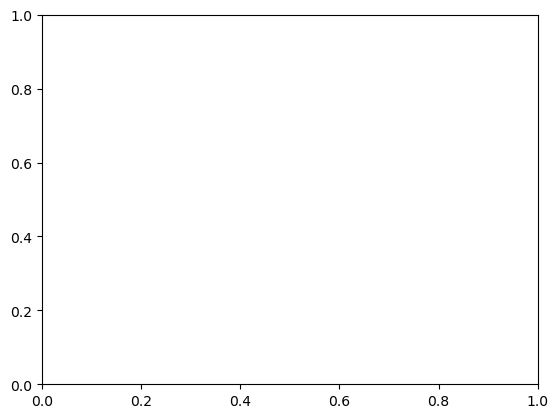

In [1]:
import koma.oma, koma.plot
import numpy as np
import matplotlib.pyplot as plt
import koma.clustering
import geneate_vibration_data
import strid

from scipy.signal import detrend, welch, resample

from knutils.modal import statespace as to_A
from knutils.structural import shearframe
from beef.newmark import newmark_lin
import plot_koma

In [2]:
path = "vibration_data/data_stochastic_3_floor_"

number_of_realizations = 100

### Data generation

In [3]:
#for i in range(number_of_realizations):
#    geneate_vibration_data.generate_data(9, path + str(i) + ".npz")

### Define SSI parameters

In [5]:
i = 100
s = 3

orders = np.arange(2, 50+2, 2)
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

### Cov-SSI call and pole clustering

In [15]:
freq_modes = []

for j in range(number_of_realizations):

    data = np.load(path + str(j) + ".npz")
    y = data["y"]
    fs = data["fs"]
    true_f = data["true_frequencies"].transpose()
    true_xi = data["true_damping"].transpose()
    true_modeshapes = data["true_modeshapes"].transpose()

    # Cov-SSI
    ssid = strid.CovarianceDrivenStochasticSID(y, fs) #, ix_references)
    modes = {}
    for order in orders:
        A, C, G, R0 = ssid.perform(order, i)
        modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)

    # Sorting routine
    lambdas = []
    phis = []

    for order in modes.keys():
        modes_in_order = modes[order]
        lambdas_in_order = []
        phis_in_order = []
        for mode in modes_in_order:
            lambdas_in_order.append(mode.eigenvalue)
            phis_in_order.append(mode.eigenvector)
        lambdas.append(np.array(lambdas_in_order))
        phis.append(np.array(phis_in_order).transpose())

    lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambdas, phis, orders, s, stabcrit=stabcrit, valid_range={'freq': [0, np.inf], 'damping':[0, 0.95]}, indicator='freq', return_both_conjugates=False)

    #Pole clustering
    pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
    prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
    args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

    xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

    #plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

    xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
    fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

    xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
    fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

    freq_modes.append([freq for freq in fn_mean])


#freq_modes = np.array(freq_modes)

(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles
HDBSCAN
(9, 59723)
4.964278725061392
Cov-SSI
Find stable poles


In [16]:
import itertools
freq_modes_sorted = list(map(list, itertools.zip_longest(*freq_modes, fillvalue=None)))

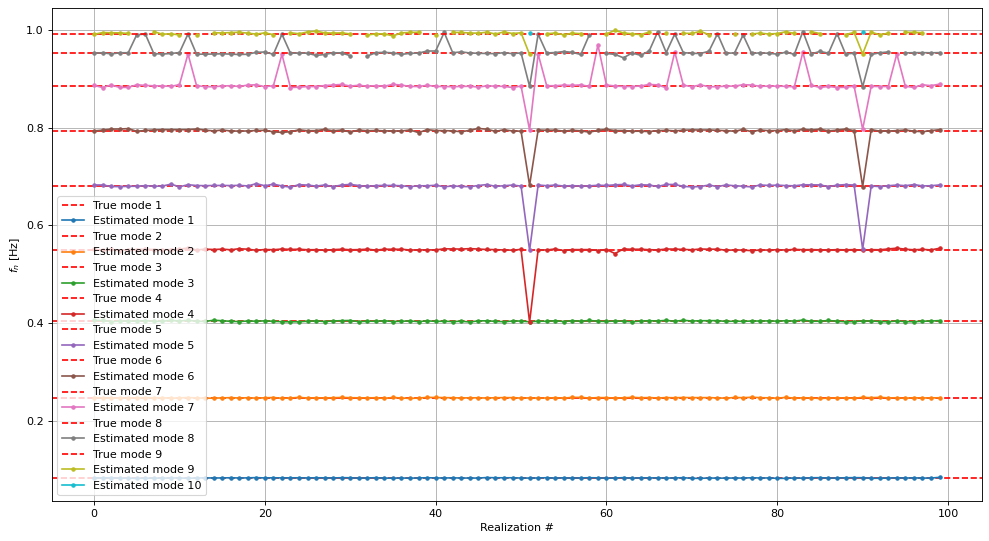

In [17]:
#Plot

plt.figure(figsize=(15, 8), dpi=80)

for i in range(len(freq_modes_sorted)):
    if (i<len(true_f)):
        plt.axhline(y = true_f[i], color = 'r', linestyle = '--', label="True mode " + str(i+1))
    plt.plot(np.arange(0, number_of_realizations), freq_modes_sorted[i], linestyle="-", marker=".", label="Estimated mode " + str(i+1))

plt.grid()
plt.legend()
plt.xlabel("Realization #")
plt.ylabel("$f_n$ [Hz]")
#plt.savefig("plots/num_example_bad.jpg")
plt.show()

In [18]:
print(true_f)

[0.08312307 0.24710182 0.40434028 0.5505494  0.68174096 0.7943364
 0.88526442 0.95204473 0.99285575]


In [19]:
print(np.meshgrid([1,2,3], [1,2,3]))

[array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]]), array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])]


In [20]:
for i in range(len(freq_modes_sorted)):
    print(np.std(freq_modes_sorted[i]))

0.0003946030990659295
0.0005325673056033563
0.0008343362568820728
0.014843457706446576
0.01848014292454021
0.015986839288119167
0.02215757067305996


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'